In [1]:
import math, time, pickle

import numpy as np
from numpy.random import seed

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# feature selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from boruta import BorutaPy
from BorutaShap import BorutaShap

# classification metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

# algs
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

In [2]:
# fixate the random state
RANDOM_STATE = 1337
seed(RANDOM_STATE)

## Helpers

In [3]:
def fit_model(model, X_train, y_train):
    start_time = time.time()
    model.fit(X_train, y_train)
    return (model, time.time() - start_time)

    
def get_number_of_pca_features(variance, threshold):
    """
    Given a cumulative_explained_variance dist and a % threshold (1-100) return the first number of features that hit that threshold.
    """
    for x in range(len(variance)):
        if(math.floor(variance[x] * 100) == threshold):
            return x


## Data Prep

In [4]:
# read in complete labeled data set
df = pd.read_csv('../datasets/PowerShellCorpus.ast.csv')

In [5]:
df.shape

(14702, 5000)

In [6]:
# split into target variable and input features
paths = df.Path
y = df.Label
X = df.drop( ['Path', 'Label'], axis=1)

In [7]:
# split into train/test set
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [8]:
X_train.head()

,AstArrayElementMetrics_CharacterDistribution_!_21_Count,AstArrayElementMetrics_CharacterDistribution_!_21_Percent,"AstArrayElementMetrics_CharacterDistribution__22_Count""","AstArrayElementMetrics_CharacterDistribution__22_Percent""",AstArrayElementMetrics_CharacterDistribution_#_23_Count,AstArrayElementMetrics_CharacterDistribution_#_23_Percent,AstArrayElementMetrics_CharacterDistribution_$_24_Count,AstArrayElementMetrics_CharacterDistribution_$_24_Percent,AstArrayElementMetrics_CharacterDistribution_%_25_Count,AstArrayElementMetrics_CharacterDistribution_%_25_Percent,AstArrayElementMetrics_CharacterDistribution_&_26_Count,AstArrayElementMetrics_CharacterDistribution_&_26_Percent,AstArrayElementMetrics_CharacterDistribution_(_28_Count,AstArrayElementMetrics_CharacterDistribution_(_28_Percent,AstArrayElementMetrics_CharacterDistribution_)_29_Count,AstArrayElementMetrics_CharacterDistribution_)_29_Percent,AstArrayElementMetrics_CharacterDistribution_*_2a_Count,AstArrayElementMetrics_CharacterDistribution_*_2a_Percent,"AstArrayElementMetrics_CharacterDistribution_,_2c_Count","AstArrayElementMetrics_CharacterDistribution_,_2c_Percent",AstArrayElementMetrics_CharacterDistribution_._2e_Count,AstArrayElementMetrics_CharacterDistribution_._2e_Percent,AstArrayElementMetrics_CharacterDistribution_/_2f_Count,AstArrayElementMetrics_CharacterDistribution_/_2f_Percent,AstArrayElementMetrics_CharacterDistribution_:_3a_Count,AstArrayElementMetrics_CharacterDistribution_:_3a_Percent,AstArrayElementMetrics_CharacterDistribution_;_3b_Count,AstArrayElementMetrics_CharacterDistribution_;_3b_Percent,AstArrayElementMetrics_CharacterDistribution_?_3f_Count,AstArrayElementMetrics_CharacterDistribution_?_3f_Percent,AstArrayElementMetrics_CharacterDistribution_@_40_Count,AstArrayElementMetrics_CharacterDistribution_@_40_Percent,AstArrayElementMetrics_CharacterDistribution_[_5b_Count,AstArrayElementMetrics_CharacterDistribution_[_5b_Percent,AstArrayElementMetrics_CharacterDistribution_\_5c_Count,AstArrayElementMetrics_CharacterDistribution_\_5c_Percent,AstArrayElementMetrics_CharacterDistribution_]_5d_Count,AstArrayElementMetrics_CharacterDistribution_]_5d_Percent,AstArrayElementMetrics_CharacterDistribution_^_5e_Count,AstArrayElementMetrics_CharacterDistribution_^_5e_Percent,AstArrayElementMetrics_CharacterDistribution___5f_Count,AstArrayElementMetrics_CharacterDistribution___5f_Percent,AstArrayElementMetrics_CharacterDistribution_'_27_Count,AstArrayElementMetrics_CharacterDistribution_'_27_Percent,AstArrayElementMetrics_CharacterDistribution_-_2d_Count,AstArrayElementMetrics_CharacterDistribution_-_2d_Percent,AstArrayElementMetrics_CharacterDistribution_`_60_Count,AstArrayElementMetrics_CharacterDistribution_`_60_Percent,AstArrayElementMetrics_CharacterDistribution_{_7b_Count,AstArrayElementMetrics_CharacterDistribution_{_7b_Percent,...,AstVariableNameMetrics_CharacterDistribution_US_1F_Count,AstVariableNameMetrics_CharacterDistribution_US_1F_Percent,AstVariableNameMetrics_CharacterDistribution_V_56_Count,AstVariableNameMetrics_CharacterDistribution_V_56_Percent,AstVariableNameMetrics_CharacterDistribution_v_76_Count,AstVariableNameMetrics_CharacterDistribution_v_76_Percent,AstVariableNameMetrics_CharacterDistribution_VT_0B_Count,AstVariableNameMetrics_CharacterDistribution_VT_0B_Percent,AstVariableNameMetrics_CharacterDistribution_W_57_Count,AstVariableNameMetrics_CharacterDistribution_W_57_Percent,AstVariableNameMetrics_CharacterDistribution_w_77_Count,AstVariableNameMetrics_CharacterDistribution_w_77_Percent,AstVariableNameMetrics_CharacterDistribution_X_58_Count,AstVariableNameMetrics_CharacterDistribution_X_58_Percent,AstVariableNameMetrics_CharacterDistribution_x_78_Count,AstVariableNameMetrics_CharacterDistribution_x_78_Percent,AstVariableNameMetrics_CharacterDistribution_Y_59_Count,AstVariableNameMetrics_CharacterDistribution_Y_59_Percent,AstVariableNameMetrics_CharacterDistribution_y_79_Count,AstVariableNameMetrics_CharacterDistribution_y_79

## Baseline - Variance Threshold Feature Selection

In [13]:
# Simple baseline approach that removes all zero-variance features, i.e. features that have the same value in all samples
#    ref - https://scikit-learn.org/stable/modules/feature_selection.html#removing-features-with-low-variance

vt = VarianceThreshold()
_ = vt.fit(X_train)
mask = vt.get_support()

In [14]:
print(f"Total number of features       : {len(mask)}")
print(f"Non-zero variance features     : {sum(mask)}")
print(f"Zero-variance features removed : {len(mask) - sum(mask)}")

Total number of features       : 4998
Non-zero variance features     : 3449
Zero-variance features removed : 1549


In [42]:
X_train_non_zero_variance = X_train.loc[:, mask]
X_test_non_zero_variance = X_test.loc[:, mask]

## PCA Analysis

In [9]:
# standardize the data first
scaler = StandardScaler()
item_data_scaled = scaler.fit_transform(X_train)

In [10]:
# fit the PCA
pca = PCA()
pca.fit(item_data_scaled)

PCA()

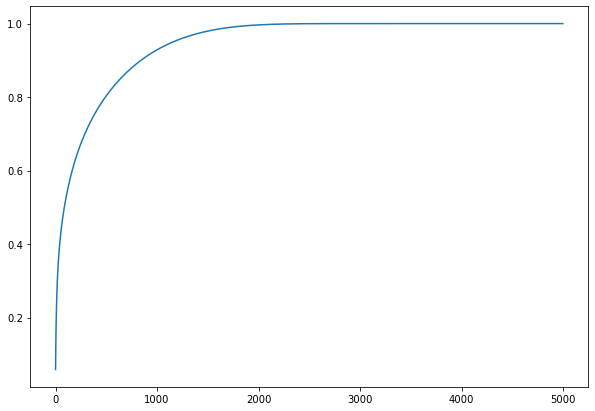

In [11]:
# plot the explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10,7))
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)
plt.show()

In [12]:
print(f"90%\texplained variance: {get_number_of_pca_features(cumulative_explained_variance, 90)} features")
print("{:.2f}%\texplained variance: 1000 features".format(cumulative_explained_variance[1000]*100))
print(f"95%\texplained variance: {get_number_of_pca_features(cumulative_explained_variance, 95)} features")
print(f"99%\texplained variance: {get_number_of_pca_features(cumulative_explained_variance, 99)} features")

90%	explained variance: 842 features
92.86%	explained variance: 1000 features
95%	explained variance: 1157 features
99%	explained variance: 1727 features


In [43]:
# extract the most important feature for each component and translate back to column name
#     ref - https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis/50845697#50845697

# get the most important feature for each of the components that explain 99% culmulative variance
n_pcs = get_number_of_pca_features(cumulative_explained_variance, 99)
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

# map back to column names
most_important_features = [X_train.columns[most_important[i]] for i in range(n_pcs)]
most_important_features = np.unique(most_important_features)

print(f"Number of selected features : {len(most_important_features)}")

X_train_pca = X_train[most_important_features]
X_test_pca = X_test[most_important_features]

print(f"X_train_pca shape           : {X_train_pca.shape}")

Number of selected features : 894
X_train_pca shape           : (11761, 894)


## Logistic Refression Lasso (L1) Feature Selection

In [10]:
# standardize the data first
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [12]:
# train a LogisticRegression classifier with L1 regularization (Lasso) so we can use it for feature selection
#    ref - https://scikit-learn.org/stable/modules/feature_selection.html#l1-based-feature-selection

results = {}

for c in [0.0001, 0.001, 0.01, 0.1, 1, 10]:

    (lr, t) = fit_model(LogisticRegression(penalty='l1', C=c, solver='saga'), X_train_scaled, y_train)

    sfm = SelectFromModel(lr, prefit=True)

    selected_feat = X_train.columns[(sfm.get_support())]
    results[c] = (lr, len(selected_feat))
    print("Model with c={} has been fit in {:.2f} seconds, resulting in {} features".format(c, t, len(selected_feat)))


Model with c = 0.0001 has been fit in 3.42 seconds, resulting in 0 features
Model with c = 0.001 has been fit in 79.53 seconds, resulting in 87 features
Model with c = 0.01 has been fit in 89.68 seconds, resulting in 786 features
Model with c = 0.1 has been fit in 114.16 seconds, resulting in 2873 features
Model with c = 1 has been fit in 105.90 seconds, resulting in 3425 features
Model with c = 10 has been fit in 107.98 seconds, resulting in 3442 features


In [13]:
(lr, t) = fit_model(LogisticRegression(penalty='l1', C=0.01, solver='saga'), X_train_scaled, y_train)

sfm = SelectFromModel(lr, prefit=True)

X_train_lasso = sfm.transform(X_train)
X_test_lasso = sfm.transform(X_test)

In [14]:
X_train_lasso.shape

(11761, 790)

## Random Forest Feature Selection

In [47]:
# train a random forest classifier as normal so we can use it for feature selection
(clf, t) = fit_model(RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE), X_train, y_train)

In [19]:
print("{0:<15} | {1:<25}".format("Threshold", "Number of Features"))
print("-"*36)

# test various SelectFromModel thesholds
for threshold in [0.000001, 0.00001, 0.0001,  0.00025, 0.0005, 0.001, 0.005, 0.01, 0.1]:
    
    sfm = SelectFromModel(clf, threshold=threshold, prefit=True)
    selected_feat = X_train.columns[(sfm.get_support())]
    print("{0:<15} | {1:<25}".format(threshold, len(selected_feat)))

Threshold       | Number of Features       
------------------------------------
1e-06           | 2901                     
1e-05           | 2558                     
0.0001          | 1147                     
0.00025         | 560                      
0.0005          | 321                      
0.001           | 173                      
0.005           | 42                       
0.01            | 13                       
0.1             | 0                        


In [51]:
sfm = SelectFromModel(clf, threshold=0.0001, prefit=True)

selected_feat= X_train.columns[(sfm.get_support())]

X_train_sfm = X_train[selected_feat]
X_test_sfm = X_test[selected_feat]

## Boruta Feature Selection

In [20]:
# "An all relevant feature selection method based on Random Forest estimators"
#     ref - https://github.com/scikit-learn-contrib/boruta_py
#     ref - https://towardsdatascience.com/boruta-shap-an-amazing-tool-for-feature-selection-every-data-scientist-should-know-33a5f01285c0

# the estimator used by Boruta
rf = RandomForestClassifier(n_jobs=-1)

boruta = BorutaPy(estimator=rf, n_estimators='auto', random_state=RANDOM_STATE, max_iter=200)

boruta.fit(np.array(X_train), np.array(y_train))

# save off the fit Boruta object
pickle.dump(boruta, open("boruta.bin", "wb"))

In [21]:
# Important features
important = list(X.columns[boruta.support_])
print(f"Number of important features             : {len(important)}")

# Tentative features
tentative = list(X.columns[boruta.support_weak_])
print(f"Number of unconfirmed/tentative features : {len(tentative)}")

# Unimportant features
unimportant = list(X.columns[~(boruta.support_ | boruta.support_weak_)])
print(f"Number of unimportant features           : {len(unimportant)}")

Number of important features             : 921
Number of unconfirmed/tentative features : 14
Number of unimportant features           : 4063


In [66]:
X_train_boruta = X_train[important]
X_test_boruta = X_test[important]

## Boruta-Shap Feature Selection

In [22]:
# Boruta feature selection using Shapley values
#    ref - https://github.com/Ekeany/Boruta-Shap

Feature_Selector = BorutaShap(importance_measure='shap', classification=True)

Feature_Selector.fit(X=X_train, y=y_train, n_trials = 100, sample=True, random_state=RANDOM_STATE)

pickle.dump(Feature_Selector, open("boruta-shap.bin", "wb"))

  0%|          | 0/100 [00:00<?, ?it/s]

446 attributes confirmed important: ['AstCmdletMetrics_CharacterDistribution_&_26_Percent', 'AstMemberArgumentMetrics_Entropy_Median', 'LineByLineMetrics_CharacterDistribution_m_6d_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_e_65_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_CharacterDistribution_{_7b_Count', 'AstGroupedBinaryExpressionOperators_Plus_Count', 'AstGroupedAstTypes_StatementBlockAst_Percent', 'LineByLineMetrics_CharacterDistribution_t_74_Percent', 'AstStringMetrics_UpperAlphaPercent_Average', 'AstMemberMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Average', 'AstCmdletMetrics_UpperAlphaPercent_Average', 'LineByLineMetrics_CharacterDistribution_(_28_Percent', 'LineByLineMetrics_CharacterDistribution_A_41_Percent', 'AstGroupedBinaryExpressionOperators_Format_Count', 'AstGroupedAstTypes_AssignmentStatementAst_Count', '

In [23]:
# Important features
print(f"Number of important features             : {len(Feature_Selector.accepted)}")

# Tentative features
print(f"Number of unconfirmed/tentative features : {len(Feature_Selector.tentative)}")

# Unimportant features
print(f"Number of unimportant features           : {len(Feature_Selector.rejected)}")

Number of important features             : 446
Number of unconfirmed/tentative features : 312
Number of unimportant features           : 4240


In [24]:
#Feature_Selector.TentativeRoughFix()

0 tentative features are now accepted: []
312 tentative features are now rejected: ['AstArrayElementMetrics_Density_Mode'
 'AstMemberArgumentMetrics_CharacterDistribution_SpecialCharacterOnly_Count'
 'LineByLineMetrics_CharacterDistribution_f_66_Percent'
 'AstVariableNameMetrics_CharacterDistribution_i_69_Count'
 'AstGroupedAstTypes_CommandExpressionAst_Count'
 'AstCmdletMetrics_CharacterDistribution_i_69_Count'
 'AstVariableNameMetrics_CharacterDistribution_/_2f_Percent'
 'AstStringMetrics_CharacterDistribution_7_37_Count'
 'AstMemberMetrics_CharacterDistribution_n_6e_Percent'
 'LineByLineMetrics_CharacterDistribution_N_4e_Count'
 'AstVariableNameMetrics_CharacterDistribution_N_4e_Percent'
 'AstCommentMetrics_CharacterDistribution_:_3a_Percent'
 'AstGroupedBinaryExpressionOperators_Imatch_Percent'
 'AstTypeExpressionMetrics_CharacterDistribution_l_6c_Percent'
 'AstCommentMetrics_CharacterDistribution_:_3a_Count'
 'AstMemberMetrics_CharacterDistribution_B_42_Percent'
 'LineByLineMetric

In [67]:
X_train_boruta_shap = X_train[Feature_Selector.accepted]
X_test_boruta_shap = X_test[Feature_Selector.accepted]

all_feature_names = np.concatenate((Feature_Selector.accepted,Feature_Selector.tentative))
X_train_boruta_shap_all = X_train[all_feature_names]
X_test_boruta_shap_all = X_test[all_feature_names]

## Experimentation with Feature Selection

In [82]:
def evaluate_model(model, X_test, y_test):
    """
    Displays the Accuracy, F1, AUROC, and graphical confusion matrix for a mode.
    """
    pred_test = model.predict(X_test)
    pred_prob_test = [p[1] for p in model.predict_proba(X_test)]
    
    return(accuracy_score(y_test, pred_test), f1_score(y_test, pred_test), roc_auc_score(y_test, pred_prob_test))


In [121]:
results = {}

rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)
results["rf_base"] = evaluate_model(rf, X_test, y_test)
print("base done")


rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train_non_zero_variance, y_train)
results["rf_non-zero-variance"] = evaluate_model(rf, X_test_non_zero_variance, y_test)
print("non-zero done")


rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train_pca, y_train)
results["rf_PCA"] = evaluate_model(rf, X_test_pca, y_test)
print("pca done")


rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train_lasso, y_train)
results["rf_LASSO"] = evaluate_model(rf, X_test_lasso, y_test)
print("LASSO done")


rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train_sfm, y_train)
results["rf_SFM"] = evaluate_model(rf, X_test_sfm, y_test)
print("SFM done")


rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train_boruta, y_train)
results["rf_Boruta"] = evaluate_model(rf, X_test_boruta, y_test)
print("Boruta done")


rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train_boruta_shap, y_train)
results["rf_Boruta-Shap"] = evaluate_model(rf, X_test_boruta_shap, y_test)

rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train_boruta_shap_all, y_train)
results["rf_Boruta-Shap-All"] = evaluate_model(rf, X_test_boruta_shap_all, y_test)

print("Boruta-Shap done")

base done
non-zero done
pca done
LASSO done
SFM done
Boruta done
Boruta-Shap done


In [122]:
print("{:37}{:25}{:25}{:25}".format("Dataset", "Accuracy", "F1", "AUROC"))
for name,result in results.items():
    print("{:30}{:25}{:25}{:25}".format(name, result[0], result[1], result[2]))

Dataset                              Accuracy                 F1                       AUROC                    
rf_base                              0.9806188371302278       0.9804593760713062       0.9964739750734156
rf_non-zero-variance                  0.981298877932676       0.9811965811965813       0.9966349110920989
rf_PCA                               0.9670180210812649       0.9663077457450504       0.9944969593266586
rf_LASSO                             0.9833390003400204       0.9832821562606618       0.9966168751589706
rf_SFM                               0.9826589595375722       0.9825760163990432        0.997038176058455
rf_Boruta                            0.9833390003400204       0.9832593098735907       0.9972585381644968
rf_Boruta-Shap                       0.9853791227473648       0.9853592100783112       0.9965516683238144
rf_Boruta-Shap-All                   0.9846990819449167        0.984646878198567       0.9966864753624529
